## Imports and Config

In [1]:
import psycopg2
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mpl_dates
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation

import os
from pathlib import Path
from configparser import ConfigParser

conf = ConfigParser()
conf.read(Path(os.getcwd()) / 'logging_config.ini')
local_timezone = timezone(conf['logging'].get('local_timezone', 'UTC'))

conn = psycopg2.connect(
    host=conf['postgres'].get('hostname'),
    database=conf['postgres'].get('database'),
    port=conf['postgres'].get('port', 5432),
    user=conf['postgres'].get('username'),
    password=conf['postgres'].get('password')
)
cur = conn.cursor()

## Fetch the most recent data

In [2]:
df = pd.read_sql(
    """
    select 
        *, 
        temp_mcp*1.8+32 as temp_mcp_f, 
        temp_tmp*1.8+32 as temp_tmp_f, 
        temp_scd*1.8+32 as temp_scd_f, 
        temp_rtc*1.8+32 as temp_rtc_f, 
        temp_avg*1.8+32 as temp_avg_f
    from env_log
    %s
    """ % ("where ts_load_utc >= current_timestamp - interval '48 hours'" if False else ""),
    conn
)
df['ts_load_utc'] = df.ts_load_utc.dt.tz_localize(timezone('UTC'))

## Assemble the Chart

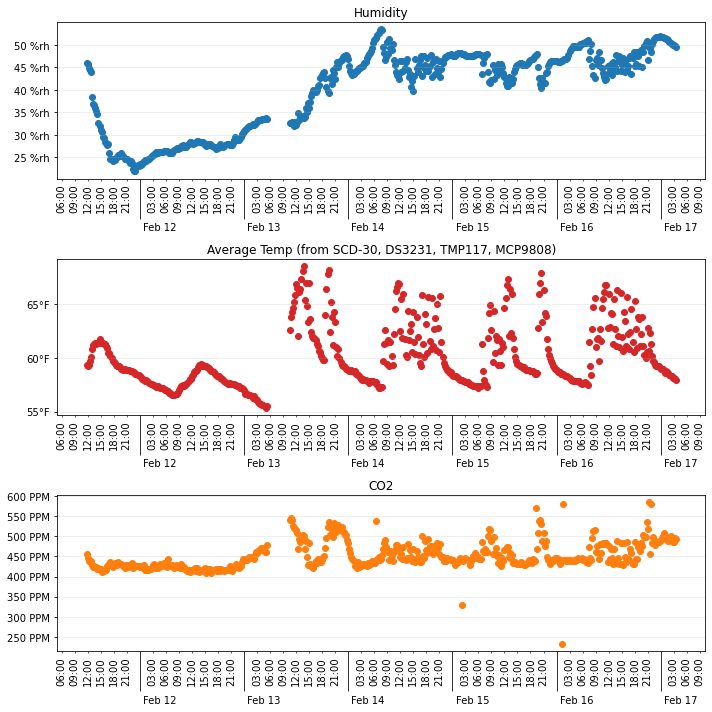

In [3]:
gs = gridspec.GridSpec(3, 1)
plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(10,10))
(ax1, ax2, ax3) = [fig.add_subplot(gs[loc[0], loc[1]]) for loc in [[x,0] for x in range(3)]]
for ax, column, title, color, append, locator_multiple in zip(
    (ax1, ax2, ax3), 
    ('humidity', 'temp_avg_f', 'co2'),
    ('Humidity', 'Average Temp (from SCD-30, DS3231, TMP117, MCP9808)', 'CO2'),
    ('tab:blue', 'tab:red', 'tab:orange'),
    (' %rh', '°F', ' PPM'),
    (5, 5, 50)
):
    ax.xaxis.set_major_locator(mpl_dates.DayLocator(interval=1, tz=local_timezone))
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d', tz=local_timezone)) 
    ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[x for x in range(0,24,3)], tz=local_timezone))
    ax.xaxis.set_minor_formatter(mpl_dates.DateFormatter('%H:00', tz=local_timezone)) 

    ax.set_title(title)

    ax.scatter(
        df.ts_load_utc,
        df[column],
        color=color
    )

    ax.yaxis.set_major_locator(ticker.MultipleLocator(locator_multiple))
    ax.yaxis.set_major_formatter('{x:1.0f}%s'%append)
    ax.grid(axis='y', which='major', visible=True, alpha=0.25)
    ax.tick_params(axis='x', which='major', direction='out', length=40, bottom=True)
    ax.tick_params(axis='x', which='minor', labelrotation=90)

    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + ScaledTranslation(xt=20/fig.dpi,yt=0,scale_trans=fig.dpi_scale_trans))
fig.set_facecolor('white')


## Save the Figure Output

In [4]:
fig.savefig(
    Path(os.getcwd()) / 'env_log_plot.png',
    dpi=300,
    backend='agg',
    metadata={
        'Title': 'Env Logs: %s' % df.loc[0, 'location'],
        'Description': 'Humidity, Temperature, and CO2 for %s' % df.loc[0, 'location'],
        'Software': 'matplotlib'
    }
)